# Rock-Paper-Scissors
online: https://colab.research.google.com/drive/1XDgJ5A3nhI2bfoeHA3FJ3MkEHFc1tuq2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import numpy as np
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

## Adatbetöltés


In [ ]:
(ds_train, ds_test), ds_info = tfds.load('rock_paper_scissors', split=['train', 'test'], as_supervised=True, with_info=True)



def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.
  image = tf.image.resize(image, (150,150))
  return image, label

ds_train = ds_train.map(format_example)
ds_test = ds_test.map(format_example)




Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.4A6NDV_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.4A6NDV_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
get_label_name = ds_info.features['label'].int2str

def preview_dataset(dataset):
    plt.figure(figsize=(16, 10))
    plot_index = 0
    for image, label in dataset.take(16):
    #(image, label) = features
      plot_index += 1
      plt.subplot(4, 8, plot_index)
      # plt.axis('Off')
      label = get_label_name(label.numpy())
      plt.title('Label: %s' % label)
      plt.imshow(image.numpy())


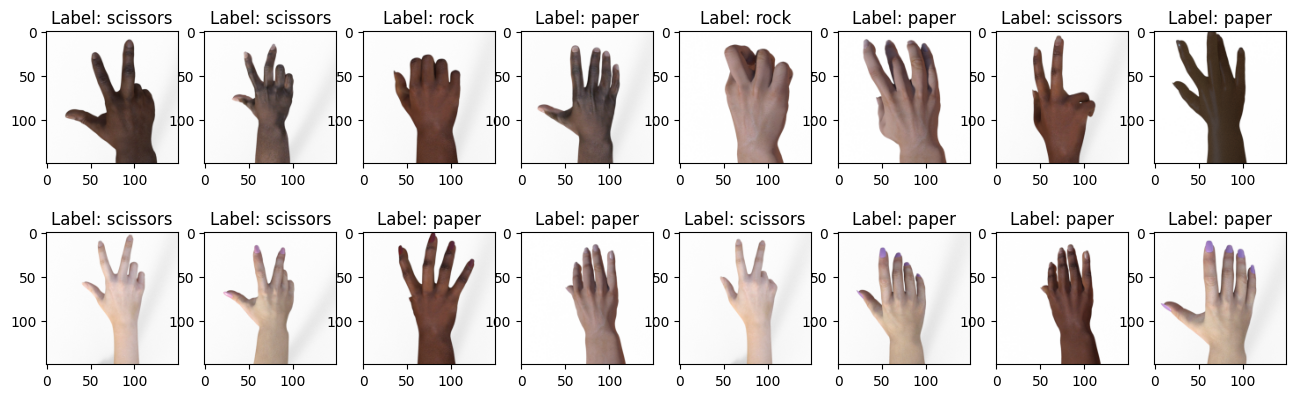

In [ ]:
preview_dataset(ds_train)

#Modell Választás

## CNN model

In [ ]:
model = Sequential([
    Input(shape=(150,150, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:

train_size = int(0.8 * len(ds_train))
val_size = len(ds_train) - train_size



ds_train_baseline = ds_train.take(train_size).batch(32).cache().prefetch(tf.data.AUTOTUNE)
ds_val_baseline = ds_train.skip(train_size).batch(32).cache().prefetch(tf.data.AUTOTUNE)
ds_test_baseline = ds_train.batch(32).cache().prefetch(tf.data.AUTOTUNE)


history = model.fit(ds_train_baseline, epochs=2, validation_data=ds_val_baseline)


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.5781 - loss: 0.9906 - val_accuracy: 0.9782 - val_loss: 0.1017
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9773 - loss: 0.0735 - val_accuracy: 1.0000 - val_loss: 0.0020


In [ ]:

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(ds_test_baseline)
print(f"Test Accuracy: {test_accuracy:.2f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9978 - loss: 0.0073
Test Accuracy: 1.00


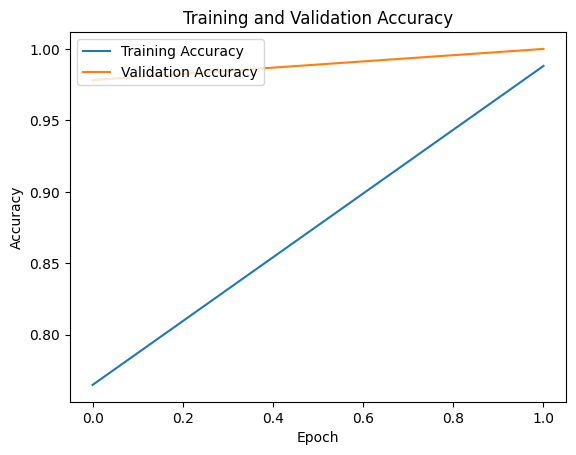

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
model.save('baseline_cnn_model.keras')

## Sima neurális háló

In [ ]:
fcnn_model = Sequential([
    Input(shape=(150, 150, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

fcnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fcnn_history = fcnn_model.fit(ds_train_baseline, epochs=2, validation_data=ds_val_baseline)

fcnn_test_loss, fcnn_test_accuracy = fcnn_model.evaluate(ds_test_baseline)
print(f"FCNN Test Accuracy: {fcnn_test_accuracy:.2f}")


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3669 - loss: 8.7374 - val_accuracy: 0.6012 - val_loss: 0.8191
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6733 - loss: 0.7604 - val_accuracy: 0.8651 - val_loss: 0.3974
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.4082
FCNN Test Accuracy: 0.85


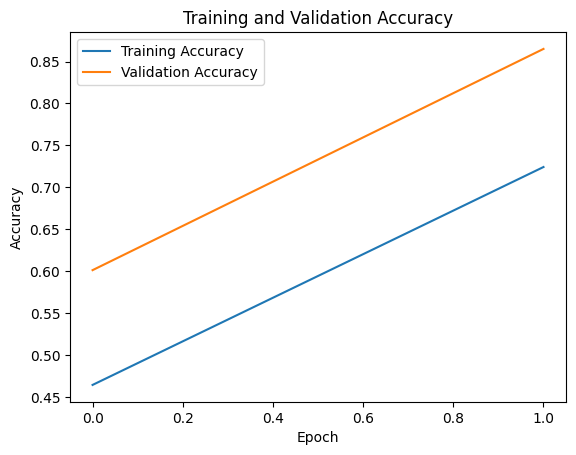

In [ ]:
plt.plot(fcnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(fcnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.show()

## Data transzform SVM-re és GMM re

In [ ]:
def prepare_data(dataset):
    images, labels = [], []
#    for batch in dataset:
 #       batch_images, batch_labels = batch
    for img, label in dataset:#zip(batch_images, batch_labels):
        img = tf.image.resize(img, (150, 150))
        img_flattened = tf.reshape(img, [-1]).numpy()
        images.append(img_flattened)
        labels.append(label.numpy())
    return np.array(images), np.array(labels)




In [ ]:
train_images, train_labels = prepare_data(ds_train)
test_images, test_labels = prepare_data(ds_test)

## SVM

In [ ]:

svm_model = SVC(kernel='rbf', C=1, gamma='scale',verbose=True)
history_svm = svm_model.fit(train_images, train_labels)

svm_predictions = svm_model.predict(test_images)
svm_accuracy = np.mean(svm_predictions == test_labels)
print(f"SVM Test Accuracy: {svm_accuracy:.2f}")


[LibSVM]SVM Test Accuracy: 0.66


## GMM

In [ ]:

gmm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
history_gmm= gmm.fit(train_images)

gmm_predictions = gmm.predict(test_images)
gmm_accuracy = np.mean(gmm_predictions == test_labels)
print(f"GMM Test Accuracy: {gmm_accuracy:.2f}")

GMM Test Accuracy: 0.30


**Baseline egyértelműen a CNN**

# Model opt

## Data augmentáció

In [ ]:
@tf.function
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [ ]:
@tf.function
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [ ]:
@tf.function
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [ ]:
@tf.function
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [ ]:
@tf.function
def augment_zoom_old(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    return tf.cond(choice < 0.00001, lambda: image, lambda: random_crop(image))

In [ ]:
@tf.function
def augment_zoom(image: tf.Tensor, min_zoom=0.2, max_zoom=0.4) -> tf.Tensor:

    zoom_factor = np.random.uniform(1 - min_zoom, 1 - max_zoom)

    height, width, _ = image.shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    zoomed = tf.image.resize(image, (new_height, new_width))
    scaled_image =  tf.image.resize_with_crop_or_pad(zoomed, height, width)
    pad_top = (len(scaled_image)-len(zoomed))
    pad_left = (150 - zoomed.shape[1]) // 2
    pad_right = 150 - zoomed.shape[1] - pad_left

    scaled_image = tf.pad(
            zoomed,
            paddings=[[pad_top, 0], [pad_left, pad_right], [0, 0]],
            mode='CONSTANT',
            constant_values=1.0
        )
    return scaled_image


In [ ]:
@tf.function
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [ ]:
@tf.function
def augment_data2(image, label):
    image = augment_flip(image)
    # image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    # image = augment_inversion(image)
    return image, label

In [ ]:
@tf.function
def augment_data3(image, label):
    # image = augment_flip(image)
    image = augment_color(image)
    # image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [ ]:
ds_train_concat = ds_train.concatenate(ds_train.map(augment_data))
ds_train_concat = ds_train_concat.concatenate(ds_train.map(augment_data2))
ds_train_concat = ds_train_concat.concatenate(ds_train.map(augment_data3))

train_size = int(0.8 * len(ds_train_concat))
val_size = len(ds_train_concat) - train_size

ds_train_aug_all = ds_train_concat.shuffle(train_size+val_size).batch(32).shuffle(train_size+val_size).cache().prefetch(tf.data.AUTOTUNE)

dataset_train_augmented = ds_train_concat.take(train_size).shuffle(train_size).batch(32).shuffle(train_size).cache().prefetch(tf.data.AUTOTUNE)
dataset_val_augmented = ds_train_concat.skip(train_size).shuffle(val_size).batch(32).shuffle(val_size).cache().prefetch(tf.data.AUTOTUNE)


#dataset_test_augmented = ds_test.concatenate(ds_test.map(augment_data)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
ds_test_c = ds_test.concatenate(ds_test.map(augment_data))
ds_test_c2 = ds_test_c.concatenate(ds_test.map(augment_data2))
ds_test_c3 = ds_test_c2.concatenate(ds_test.map(augment_data3))

ds_test = ds_test.batch(32).cache().prefetch(tf.data.AUTOTUNE)
ds_test_c=ds_test_c.batch(32).cache().prefetch(tf.data.AUTOTUNE)
ds_test_c2=ds_test_c2.batch(32).cache().prefetch(tf.data.AUTOTUNE)
ds_test_c3=ds_test_c3.batch(32).cache().prefetch(tf.data.AUTOTUNE)

## Modellek
(jobbikat megtartjuk másikat módosítjuk)


In [ ]:

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    #Dropout(0.5),

    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:

model2 = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),

    Dropout(0.5),

    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(dataset_train_augmented, epochs=30, validation_data=dataset_val_augmented)


Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 60s 110ms/step - accuracy: 0.3367 - loss: 1.2978 - val_accuracy: 0.6900 - val_loss: 0.8270
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.7421 - loss: 0.6002 - val_accuracy: 0.9688 - val_loss: 0.1507
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9428 - loss: 0.1695 - val_accuracy: 0.9876 - val_loss: 0.0638
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9637 - loss: 0.1019 - val_accuracy: 0.9861 - val_loss: 0.0509
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9771 - loss: 0.0689 - val_accuracy: 0.9965 - val_loss: 0.0246
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9842 - loss: 0.0527 - val_accuracy: 0.9985 - val_loss: 0.0141
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9802 - loss: 0.0680 - val_accuracy: 0.9836 - val_loss: 0.0514
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9897 - loss: 0.0361 - va

In [ ]:
history2 = model2.fit(dataset_train_augmented, epochs=30, validation_data=dataset_val_augmented)

Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3987 - loss: 1.0899 - val_accuracy: 0.8894 - val_loss: 0.5090
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8247 - loss: 0.4429 - val_accuracy: 0.9816 - val_loss: 0.1180
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9113 - loss: 0.2284 - val_accuracy: 0.9960 - val_loss: 0.0403
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9439 - loss: 0.1633 - val_accuracy: 0.9886 - val_loss: 0.0521
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9538 - loss: 0.1357 - val_accuracy: 0.9955 - val_loss: 0.0421
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9612 - loss: 0.1092 - val_accuracy: 0.9950 - val_loss: 0.0254
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9685 - loss: 0.0910 - val_accuracy: 0.9975 - val_loss: 0.0210
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9667 - loss: 0.0982 - val_

## kiértékelés

In [ ]:
def print_ds_tests(model):
  test_loss, test_accuracy = model.evaluate(ds_test)
  print(f"Test Accuracy: {test_accuracy:2f}")

  test_loss, test_accuracy = model.evaluate(ds_test_c)
  print(f"Test Accuracy: {test_accuracy:2f}")

  test_loss, test_accuracy = model.evaluate(ds_test_c2)
  print(f"Test Accuracy: {test_accuracy:2f}")

  test_loss, test_accuracy = model.evaluate(ds_test_c3)
  print(f"Test Accuracy: {test_accuracy:2f}")

In [ ]:
print_ds_tests(model)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.8330 - loss: 0.9936
Test Accuracy: 0.830645
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8431 - loss: 0.8787
Test Accuracy: 0.860215
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8531 - loss: 0.7815
Test Accuracy: 0.871864
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8575 - loss: 0.7362
Test Accuracy: 0.880376


In [ ]:
print_ds_tests(model2)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8117 - loss: 0.8597
Test Accuracy: 0.795699
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8111 - loss: 0.8125
Test Accuracy: 0.805108
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8046 - loss: 0.7867
Test Accuracy: 0.806452
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8194 - loss: 0.7101
Test Accuracy: 0.831317


In [ ]:
def render_training_history(training_history,first=0):
    loss = training_history.history['loss'][first:]
    val_loss = training_history.history['val_loss'][first:]

    accuracy = training_history.history['accuracy'][first:]
    val_accuracy = training_history.history['val_accuracy'][first:]

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Val set', linestyle='--')
    plt.legend()
    my_xticks = ['John','Arnold','Mavis','Matt']
    plt.xticks([i for i in range(0,len(loss),5)], [i+first for i in range(0,len(loss),5)])
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)


    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Val set', linestyle='--')
    plt.legend()
    plt.xticks([i for i in range(0,len(loss),5)], [i+first for i in range(0,len(loss),5)])
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

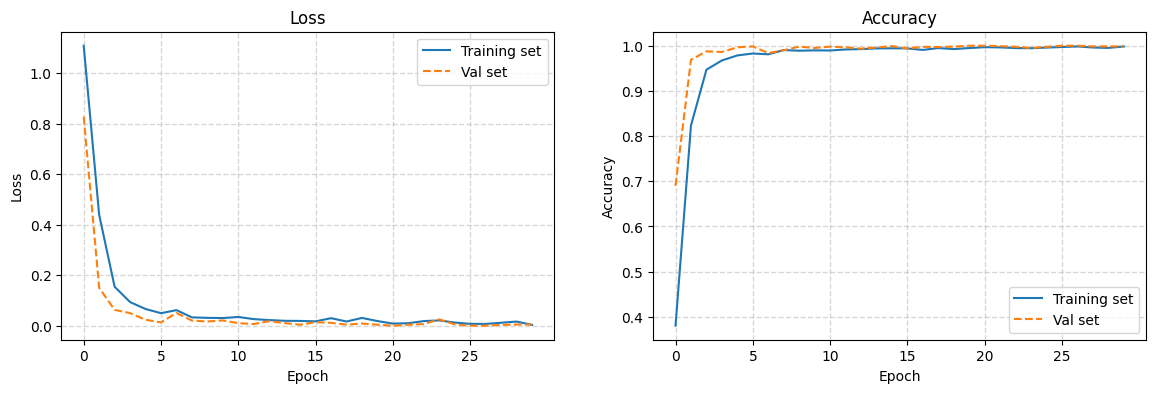

In [ ]:
render_training_history(history)

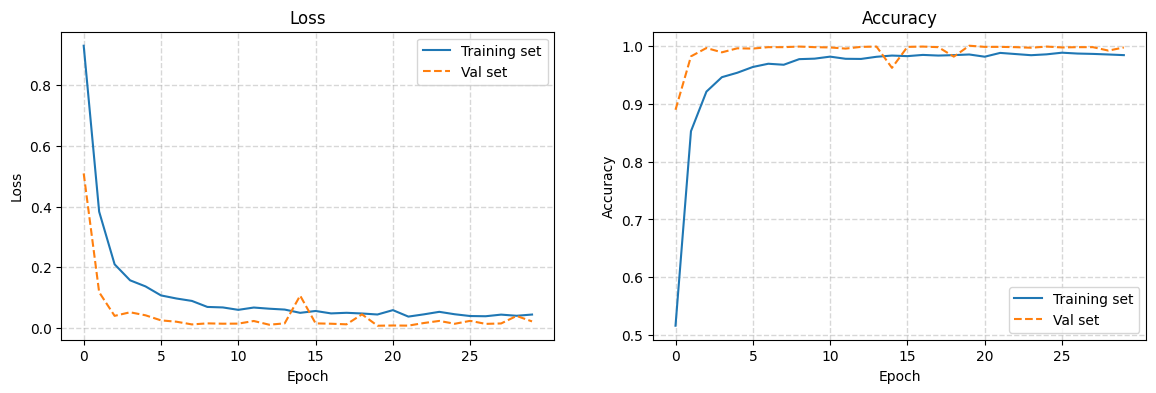

In [ ]:
render_training_history(history2)

In [ ]:
def print_confusion_matrix(model,ds_test):
  ds_test_labels = [label.numpy() for _, label in ds_test.unbatch()]

  predicted_labels = np.argmax(model.predict(ds_test), axis=1)

  confusion_matrix = tf.math.confusion_matrix(ds_test_labels,
      predicted_labels,
      num_classes=3,
      dtype=tf.dtypes.int32)

  print(confusion_matrix)

In [ ]:
print_confusion_matrix(model,ds_test)
print_confusion_matrix(model,ds_test_c)
print_confusion_matrix(model,ds_test_c2)
print_confusion_matrix(model,ds_test_c3)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
tf.Tensor(
[[110   2  12]
 [  0 124   0]
 [ 12  37  75]], shape=(3, 3), dtype=int32)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
tf.Tensor(
[[223   5  20]
 [  0 235  13]
 [ 13  53 182]], shape=(3, 3), dtype=int32)
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
tf.Tensor(
[[338   8  26]
 [  3 348  21]
 [ 12  73 287]], shape=(3, 3), dtype=int32)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
tf.Tensor(
[[447  16  33]
 [  2 449  45]
 [ 16  66 414]], shape=(3, 3), dtype=int32)


In [ ]:
print_confusion_matrix(model2,ds_test)
print_confusion_matrix(model2,ds_test_c)
print_confusion_matrix(model2,ds_test_c2)
print_confusion_matrix(model2,ds_test_c3)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
tf.Tensor(
[[112   7   5]
 [  0  80  44]
 [ 19   1 104]], shape=(3, 3), dtype=int32)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
tf.Tensor(
[[225  12  11]
 [  4 178  66]
 [ 25  27 196]], shape=(3, 3), dtype=int32)
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
tf.Tensor(
[[346  13  13]
 [  6 263 103]
 [ 33  48 291]], shape=(3, 3), dtype=int32)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
tf.Tensor(
[[469  12  15]
 [ 14 364 118]
 [ 38  54 404]], shape=(3, 3), dtype=int32)


In [ ]:
model.save("model.keras")
model2.save("model2.keras")

### pár tesztkép programból

In [ ]:
import cv2

In [ ]:
def normalize_image(image):
    normalized_image = cv2.resize(image, (150, 150))
    normalized_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB)
    normalized_image = normalized_image.astype("float32") / 255.0
    normalized_image = np.expand_dims(normalized_image, axis=0)
    return normalized_image


In [ ]:
def kez_meghatarozas(nparray):
  index = np.argmax(nparray[0])
  if index == 0:
      return 'Kő'
  elif index == 1:
      return 'Papír'
  elif index == 2:
      return 'Olló'
  else:
      return 'Hiba'

In [ ]:
from tensorflow import keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[7.7898578e-14 5.3116245e-10 1.0000000e+00]]
[[9.9749184e-01 2.5079870e-03 2.0779194e-07]]
Olló
Kő


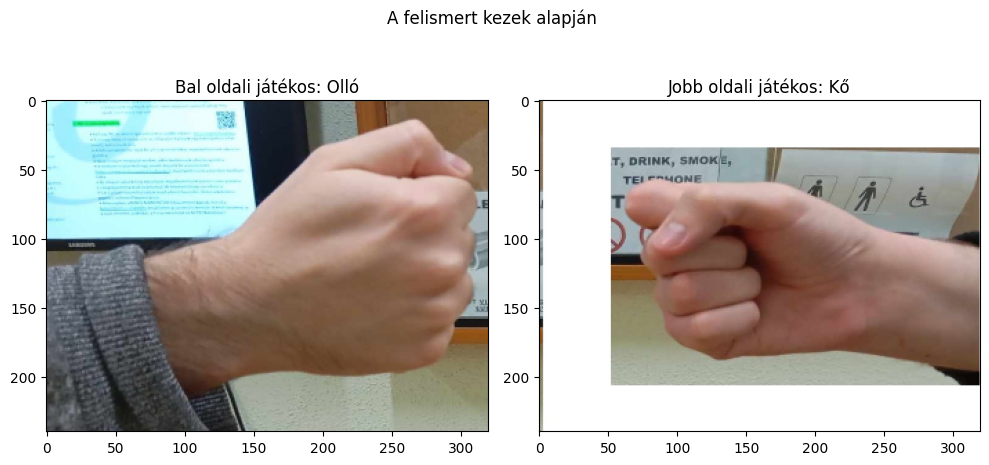

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[4.7943098e-07 9.5866245e-01 4.1337114e-02]]
[[9.9863309e-01 1.3618749e-03 5.0472790e-06]]
Papír
Kő


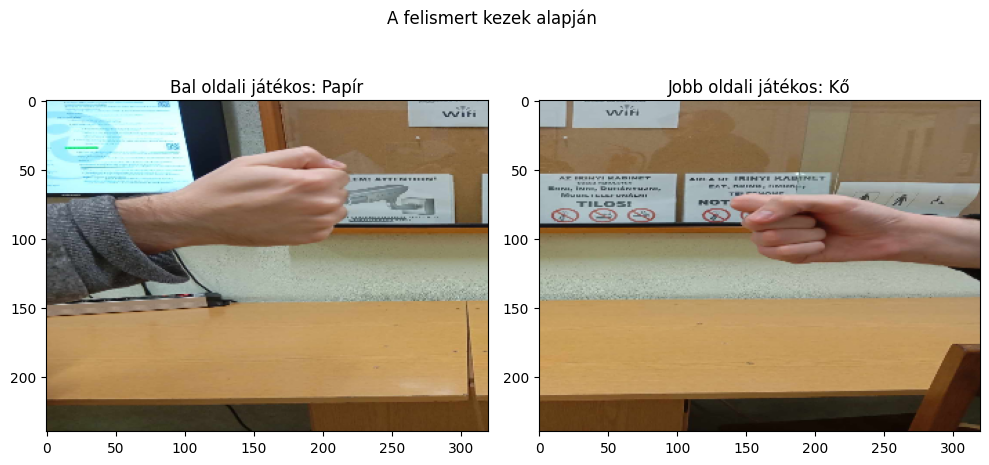

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[1.0745184e-06 9.7306108e-01 2.6937889e-02]]
[[9.956623e-01 4.294252e-03 4.342489e-05]]
Papír
Kő


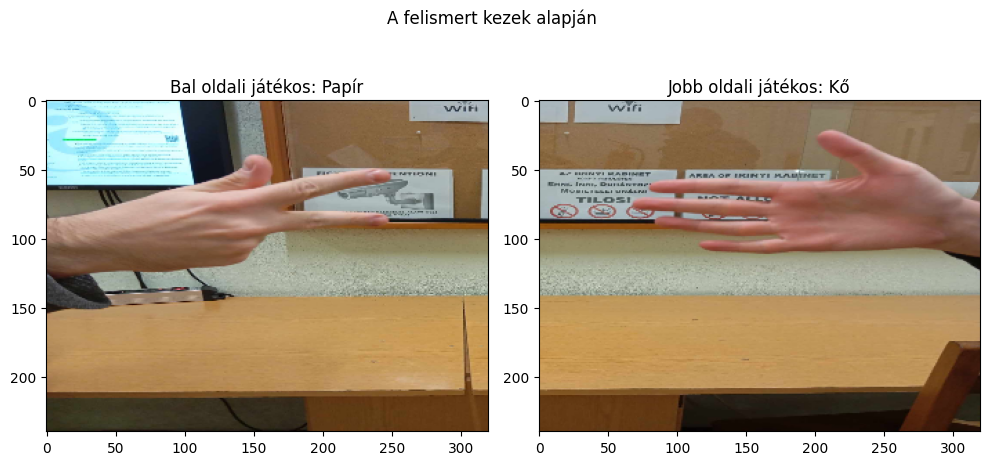

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[9.6191514e-05 2.1748850e-02 9.7815496e-01]]
[[0.49103078 0.45590764 0.0530616 ]]
Olló
Kő


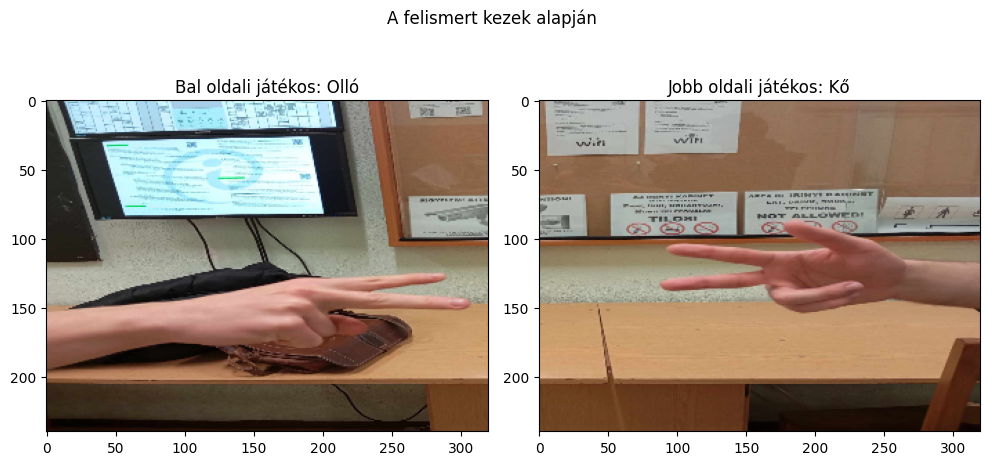

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[7.8657377e-01 2.1286842e-01 5.5784651e-04]]
[[0.05527491 0.9324653  0.01225977]]
Kő
Papír


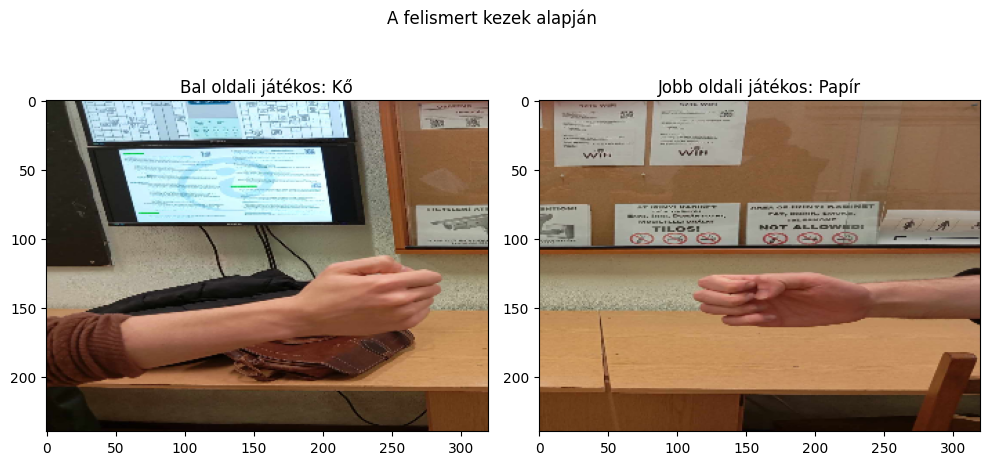

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.0030916  0.32410556 0.6728028 ]]
[[0.8705061  0.12849602 0.00099785]]
Olló
Kő


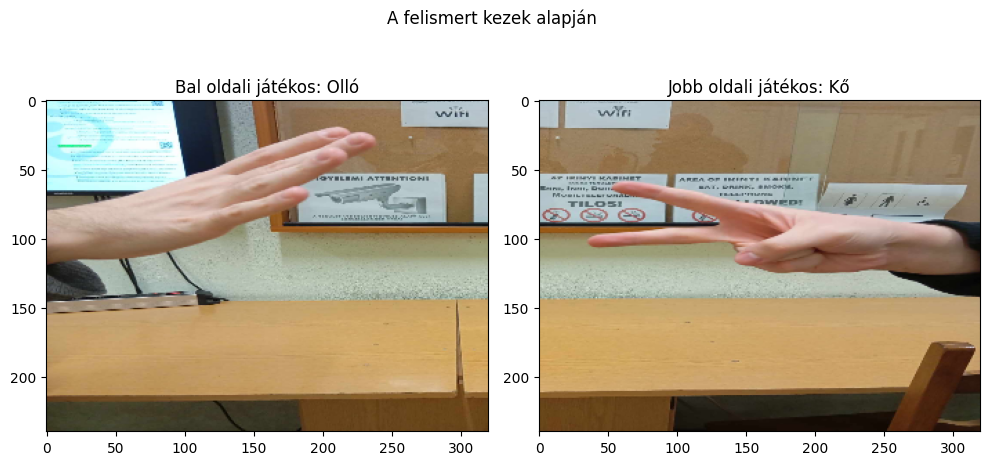

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.0023134  0.9380825  0.05960409]]
[[9.9999857e-01 1.4009905e-06 1.8452193e-09]]
Papír
Kő


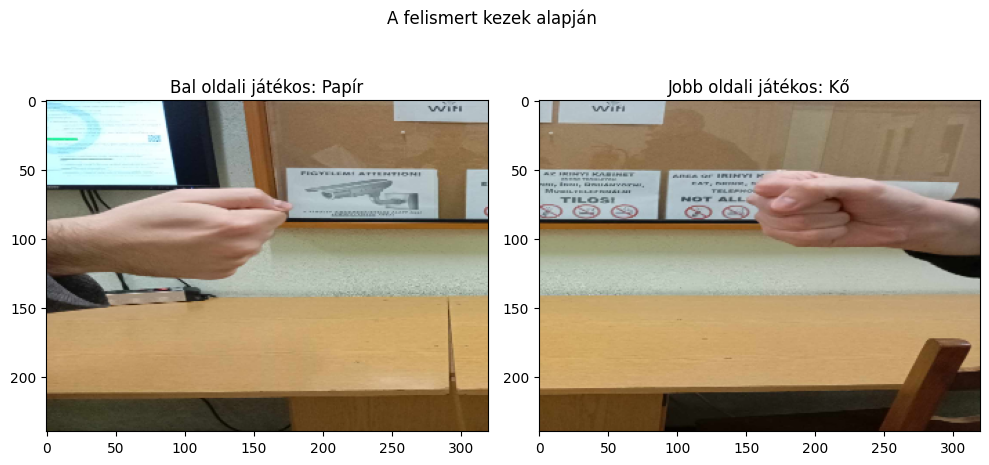

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[8.1010320e-04 9.0935194e-01 8.9837976e-02]]
[[9.3344480e-01 6.6400036e-02 1.5506538e-04]]
Papír
Kő


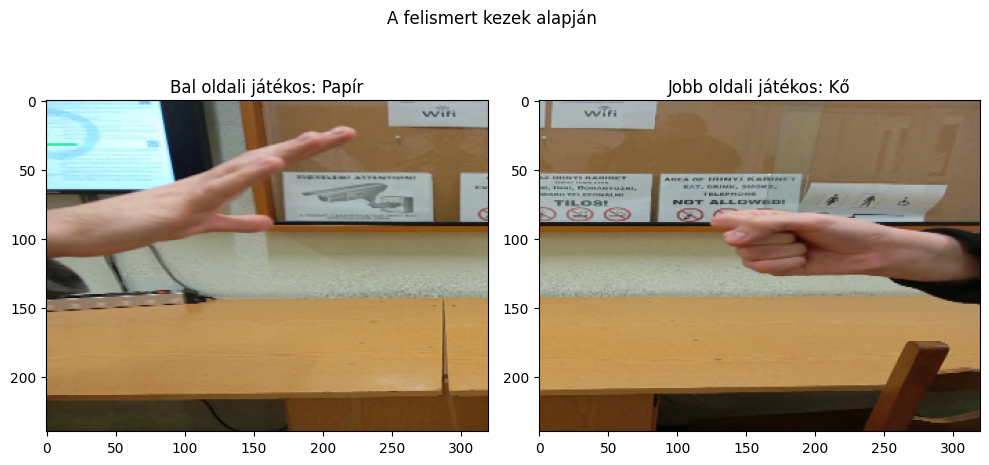

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[1.0822739e-02 5.1454507e-04 9.8866266e-01]]
[[0.1393097  0.84921265 0.01147774]]
Olló
Papír


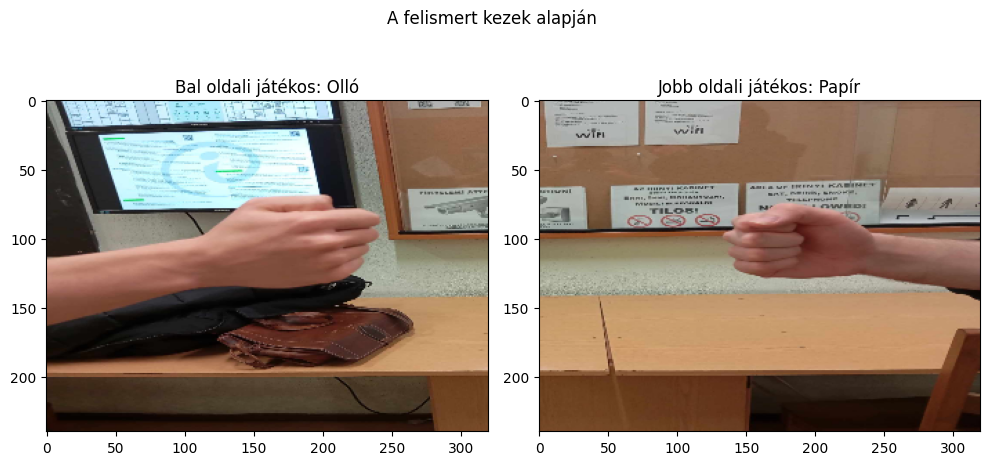

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[9.993181e-01 6.817620e-04 7.090393e-08]]
[[1.1564056e-05 2.6637233e-06 9.9998581e-01]]
Kő
Olló


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[1.05767474e-04 8.42481926e-02 9.15646076e-01]]
[[9.9999845e-01 1.4986263e-06 4.1021192e-14]]
Olló
Kő


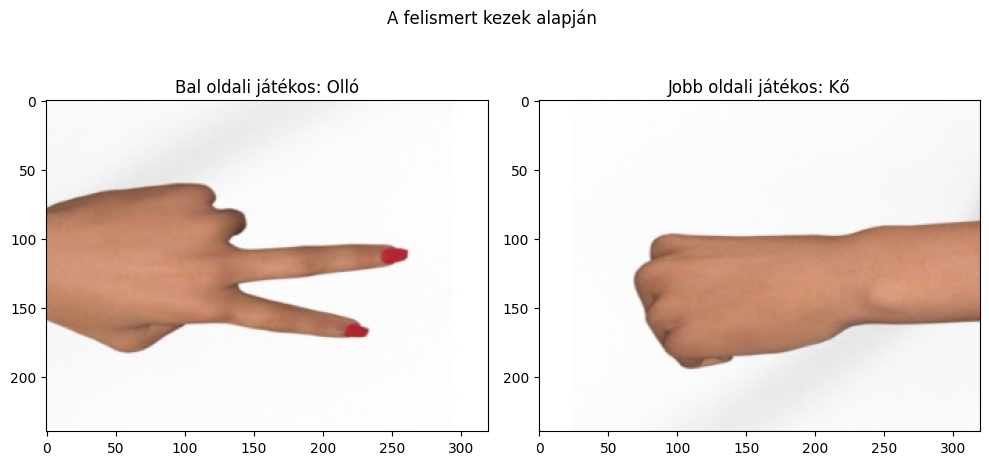

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[0.00297771 0.5439729  0.45304945]]
[[0.02892339 0.45864406 0.5124326 ]]
Papír
Olló


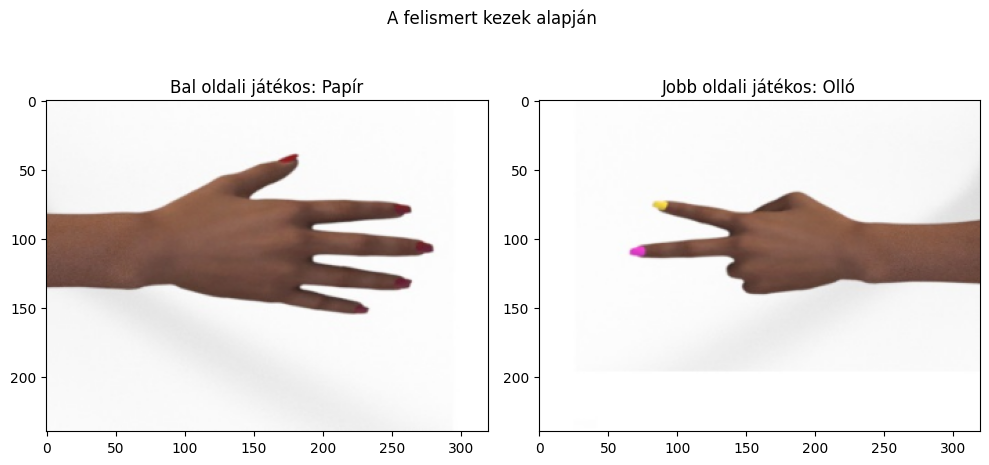

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[2.0924825e-05 4.4432719e-04 9.9953473e-01]]
[[0.32603726 0.5853273  0.08863539]]
Olló
Papír


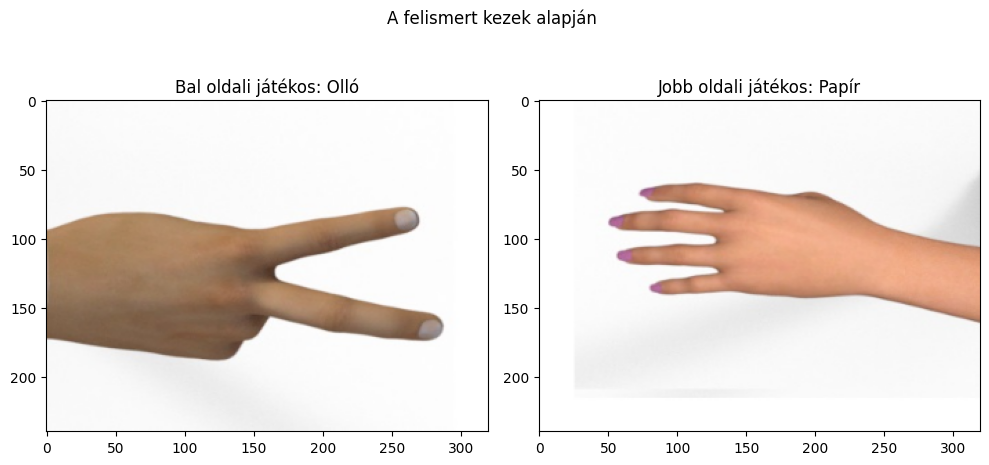

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[6.7348287e-09 9.8180371e-06 9.9999022e-01]]
[[0.00672394 0.66072726 0.33254877]]
Olló
Papír


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[0.6332771  0.26454136 0.10218155]]
[[0.20650099 0.21355264 0.5799464 ]]
Kő
Olló


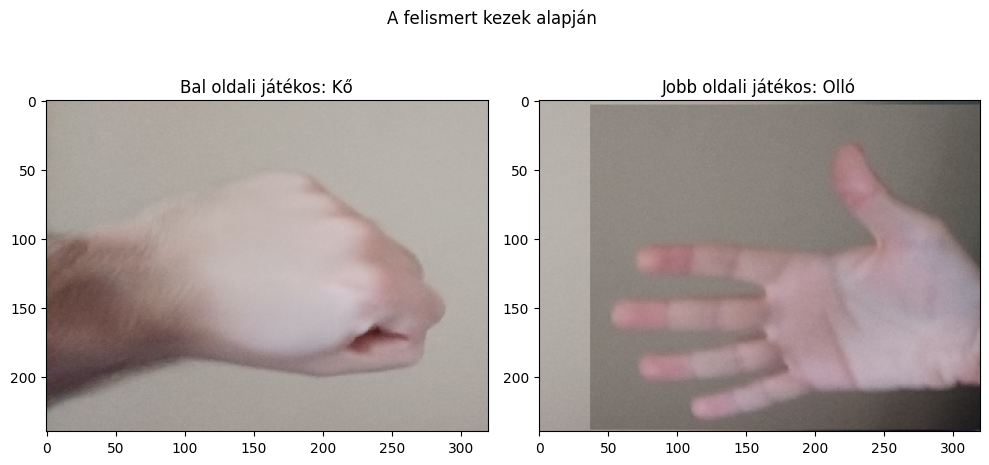

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[9.6393436e-01 3.5487171e-02 5.7845516e-04]]
[[0.20007922 0.3150384  0.48488238]]
Kő
Olló


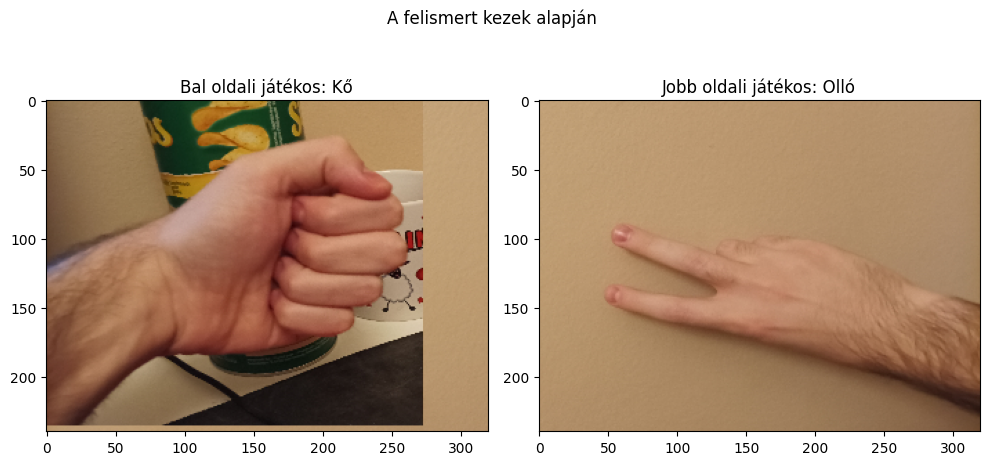

In [ ]:
test_model = model#keras.models.load_model("./baseline_cnn_model.keras")
for name in ["test1.jpg","1.jpg","2.jpg","3.jpg","4.jpg","5.jpg","6.jpg","7.jpg","8.jpg","t_1.jpg","t_2.jpg","t_3.jpg","t_4.jpg","t_5.jpg","v_1.jpg","v_2.jpg"]:
  img = cv2.imread(name)


  img_firsthalf = img[:,:int(img.shape[1]/2),:]
  img_secondhalf = img[:,int(img.shape[1]/2):int(img.shape[1]),:]


  # Normalizalas a neuralis halon valo felismeresehez
  normalized_firsthalf = normalize_image(img_firsthalf)
  normalized_secondhalf =normalize_image(img_secondhalf)

  res1 = test_model.predict(normalized_firsthalf)
  res2 = test_model.predict(normalized_secondhalf)
  print(res1)
  print(res2)

  # Plotolas
  resized_firstpart = cv2.resize(img_firsthalf, (320, 240))
  resized_secondpart = cv2.resize(img_secondhalf, (320, 240))
  img_rgb = cv2.cvtColor(resized_firstpart, cv2.COLOR_BGR2RGB)
  img_rgb2 = cv2.cvtColor(resized_secondpart, cv2.COLOR_BGR2RGB)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  kez1_string = kez_meghatarozas(res1)
  kez2_string = kez_meghatarozas(res2)
  print(kez1_string)
  print(kez2_string)


  axs[0].imshow(img_rgb)
  axs[0].set_title('Bal oldali játékos: ' + kez1_string)
  axs[1].imshow(img_rgb2)
  axs[1].set_title('Jobb oldali játékos: ' + kez2_string)
  fig.suptitle('A felismert kezek alapján ')
  fig.tight_layout()
  plt.show()